In [3]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

import sklearn
import sklearn.datasets
import scipy.io
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
from testCases import *

In [4]:
train_dataset = h5py.File('C:/Users/tarlsarv/Downloads/hyperparameter_tuning/datasets/train_signs.h5', "r")
test_dataset = h5py.File('C:/Users/tarlsarv/Downloads/hyperparameter_tuning/datasets/test_signs.h5', "r")

In [5]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

# Random initialization

In [6]:
def initialize_random_weights(layer_dims):

    L = len(layer_dims)
    parameters = {}

    for l in range(1, L):
        parameters['W'+ str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*10 # multiplying by 10 is an important step 
        parameters['b'+ str(l)] = np.random.randn(layer_dims[l], 1)

    return parameters

# He initialization

In [7]:
def initialize_he_weights(layer_dims):

    L = len(layer_dims)
    parameters = {}

    for l in range(1, L):
        parameters['W'+ str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])  
        parameters['b'+ str(l)] = np.random.randn(layer_dims[l], 1)

    return parameters

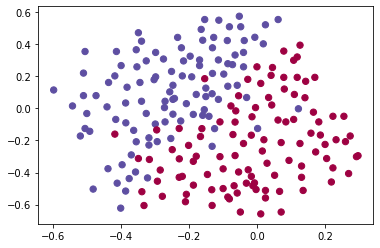

In [8]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

# Reqularization with Dropout

In [160]:
# Defining functions for reqularization and dropout for forward and backward propogation

def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):

    cache = {}
    L = len(parameters) // 2    
    for l in range(1, L):
        # print(parameters['W' + str(l)].shape)
        Z = np.dot(parameters['W' + str(l)], X) + parameters['b' + str(l)]
        A = relu(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)

        A = A * D
        A = A / keep_prob
        # print(A)
        X = A
        cache['Z' + str(l)] = Z
        cache['D' + str(l)] = D
        cache['A' + str(l)] = A
        cache['W' + str(l)] = parameters['W' + str(l)]
        cache['b' + str(l)] = parameters['b' + str(l)]

    ZL = np.dot(parameters['W' + str(L)], A) + parameters['b' + str(L)]
    AL = sigmoid(ZL)

    cache['W' + str(L)] = parameters['W' + str(L)]
    cache['b' + str(L)] = parameters['b' + str(L)]
    cache['Z' + str(L)] = ZL
    cache['A' + str(L)] = AL

    return cache['A' + str(L)], cache

In [10]:
layer_dims = [2, 2, 4, 6, 2, 2]

parameters = initialize_he_weights(layer_dims)
X = np.random.randn(2, 4)
Y = np.random.randn(2, 4)

cache = forward_propagation_with_dropout(X, parameters, keep_prob=0.5)

In [162]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):

    L = 3
    m = X.shape[1]
    WL = cache['W' + str(L)]
    AL = cache['A' + str(L)]
    dZL = AL - Y
    dWL = 1./m * np.dot(dZL, cache['A' + str(L-1)].T)
    dbL = 1./m * np.sum(dZL, axis=1, keepdims=True)
    dAL = np.dot((cache['W' + str(L)]).T, dZL)
    dAL = dAL * cache['D' + str(L-1)]
    # print("DZL before", dZL.shape)
    grads = {}

    # grads['dA' + str(L-1)] = dAL
    # print(dAL.shape)
    for l in range(L-1, 1, -1):
        # print(l)
        grads['dZ' + str(l)] = np.multiply(dAL, np.int64(cache['A' + str(l)] > 0))
        # print(cache['A' + str(l)].shape)
        # print("dZ now", grads['dZ' + str(l)].shape)
        grads['dW' + str(l)] = 1./m * np.dot(grads['dZ' + str(l)], cache['A' + str(l-1)].T)
        grads['db' + str(l)] = 1./m * np.sum(grads['dZ' + str(l)], axis=1, keepdims=True)

        grads['dA' + str(l-1)] = np.dot(parameters['W' + str(l)].T, grads['dZ' + str(l)])
        grads['dA' + str(l-1)] = grads['dA' + str(l-1)] + cache['D' + str(l-1)]

        grads['dA' + str(l-1)] = grads['dA' + str(l-1)] / keep_prob
        dAL = grads['dA' + str(l-1)]
        dZL = grads['dZ' + str(l)]
        # print("DZL after", dZL.shape)
        # grads['dA' + str(l-1)]

    return grads

In [12]:
# grads = backward_propagation_with_dropout(X, Y, cache, keep_prob=0.5)

# Regularization

While using L2 regularization just compute the cost after forward propogation. And while backpropogating just add the computed cost with regularization to the gradients.

There is no need to make changes in forward propogation function

In [151]:
def compute_cost_with_regularization(A, Y, parameters, lambd):
    m = Y.shape[1]                         # this error took my days so need to learn more of debbuging
    # print("m", m)
    cross_entropy_cost = compute_cost(A, Y)
    cost_weight_decay = 0
    L = len(parameters) //2
    regularized_cost = []
    sum_cost = 0
    # print("Cross entropy cost", cross_entropy_cost)
    for l in range(1, L+1):
        # print(l)
        cost_weight_decay = np.sum(np.square(parameters['W' + str(l)]))

        # print(np.square(parameters['W' + str(l)]))
        # cost_weight_decay = np.sum(cost_weight_decay)
        # print(str(l), cost_weight_decay)
        sum_cost += cost_weight_decay
        # print("sum_cost", sum_cost)
    regularized_cost = (1/m)*(lambd/2)*sum_cost + cross_entropy_cost


    # print("(1/m)*(lambd/2)", (1/m)*(lambd/2))
    # print("Regularized cost", regularized_cost)
    # cost = np.sum(regularized_cost)
    return regularized_cost


In [156]:
                     # to keep track of the cost
def cost_compute(train_X, train_Y):
    X = train_X
    Y = train_Y
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]

    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    a3, cache = forward_propagation(X, parameters)
    print(a3.shape)
    r_cost = compute_cost_with_regularization(a3, Y, parameters, lambd=0.7)
    return r_cost

In [157]:
cost_r = cost_compute(train_X, train_Y)

(1, 211)


In [158]:
cost_r

0.6974484493131264

In [30]:
r_cost.shape

(2, 4)

In [15]:

# def backward_propagation_with_regularization(X, Y, lambd, cache, parameters):
#     L = len(parameters) // 2
#     m = X.shape[0]
    
#     AL = cache['A' + str(L)]
#     dZL = AL - Y

#     grads = {}
#     for l in range(L-1, 0, -1):
#         grads['dZ' + str(l)] = 
        



In [16]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
   
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    # print(W1.shape)
    # print(W2.shape)
    # print(W3.shape)
    # print(A1.shape)
    # print(A2.shape)
    # print(A3.shape)
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    
    
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    # print(W3.shape, dZ3.shape)
    dA2 = np.dot(W3.T, dZ3)
    
    print()
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    #(≈ 1 lines of code)
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    # YOUR CODE STARTS HERE
    
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
   
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [166]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
   
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            print("Cost", cost.shape)
            break
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        print(grads)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)

    # print("Cost", costs)
    # plot the cost
    # plt.plot(costs)
    # plt.ylabel('cost')
    # plt.xlabel('iterations (x1,000)')
    # plt.title("Learning rate =" + str(learning_rate))
    # plt.show()
    
    return parameters

In [155]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    # print("m", m)
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    #(≈ 1 lines of code
    L2_regularization_cost = (1/m)*(lambd /2) *(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    # YOUR CODE STARTS HERE
    # W1_sum = np.sum(np.square(W1))
    # print("W1 sum", W1_sum)
    # # YOUR CODE ENDS HERE
    # print("(1/m)*(lambd /2)", (1/m)*(lambd /2))
    # print("W2 sum", np.sum(np.square(W2)))
    # print("W3 sum", np.sum(np.square(W3)))
    # print("L2_regularization_cost", L2_regularization_cost)
    # print("Sum square", (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))))

    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [167]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

{'dZ2': array([[-0.        , -0.        , -0.25316058, -0.23947415, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.2500056 ,
        -0.24111453, -0.2502058 , -0.        , -0.        , -0.25288234,
        -0.24757505, -0.24760184, -0.        , -0.25411357, -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.25300578,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.      

KeyError: 'dW1'

In [20]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572417
Cost after iteration 20000: 0.13851642423262905
On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [21]:
cache

{'Z1': array([[ 0.2279331 , -0.32085003,  0.20338082, -0.26842182],
        [-1.56087844, -0.30337779, -0.99144381, -0.44281173]]),
 'D1': array([[1, 1, 1, 1],
        [1, 1, 0, 1]]),
 'A1': array([[0.45586621, 0.        , 0.40676164, 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 'W1': array([[ 0.3971782 ,  0.4261516 ],
        [-0.7323932 , -0.30937251]]),
 'b1': array([[-0.02361012],
        [-0.84577437]]),
 'Z2': array([[ 1.68997735,  1.23480671,  1.64094771,  1.23480671],
        [ 2.04489579,  1.59075108,  1.99597666,  1.59075108],
        [ 0.13312126,  0.45677458,  0.16798424,  0.45677458],
        [-1.09408305, -1.05803753, -1.09020033, -1.05803753]]),
 'D2': array([[0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 1, 1]]),
 'A2': array([[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 3.99195332, 0.        ],
        [0.        , 0.        , 0.33596848, 0.        ],
        [0.        , 0.   

In [22]:
# rating


